# Multi-distance CTF

Please refer to [this](https://doi.org/10.1063/1.1960797) paper to get an idea how it works.

## Adjust the distance

First of all, you should adjust the distance for your experiment. You may have measured it but it should be defined with a finer precision (see below)

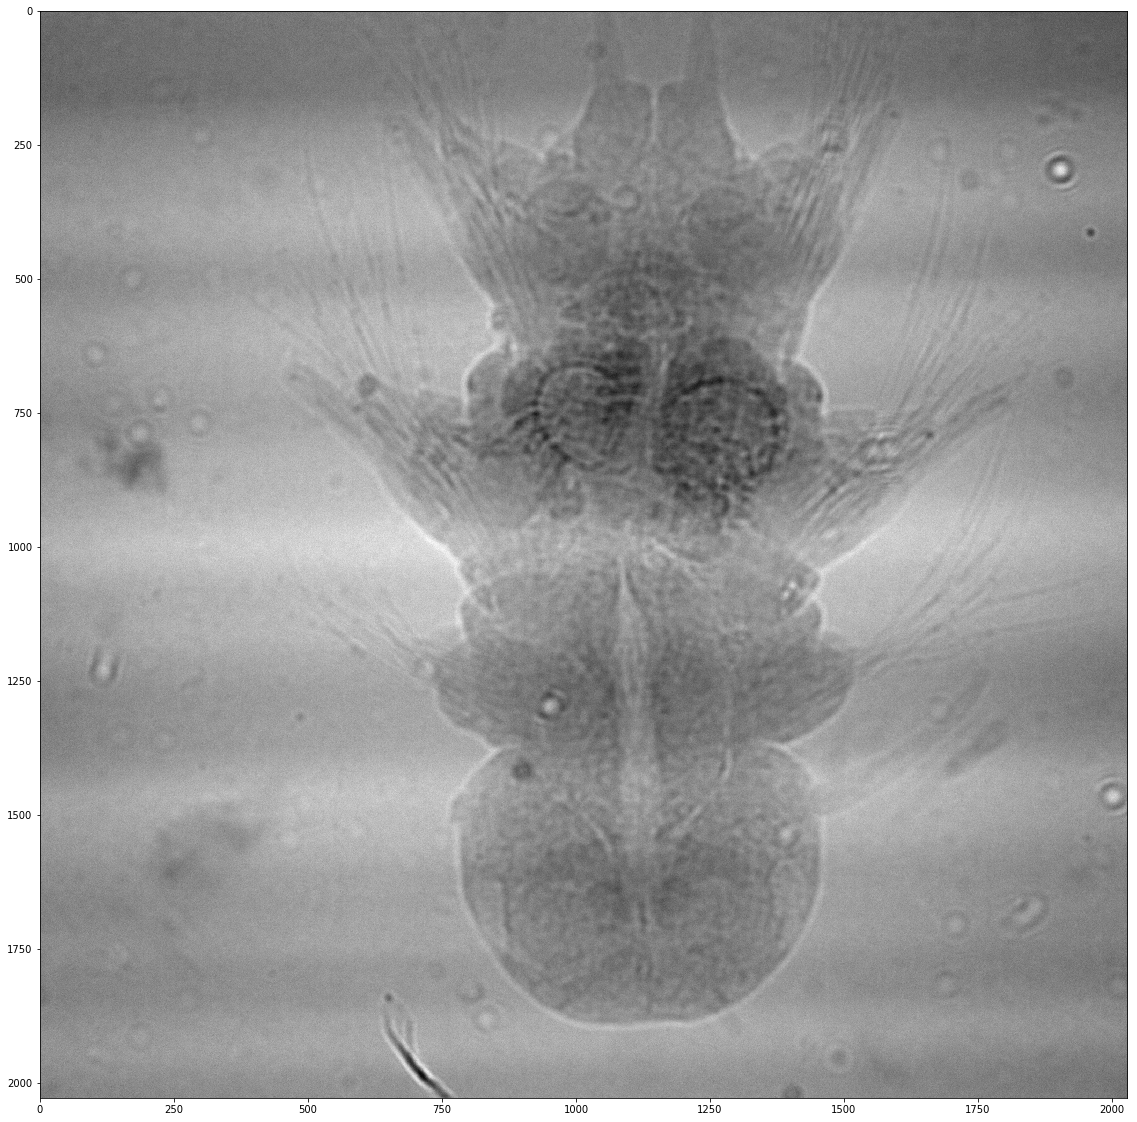

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift
from maximus48 import monochromaticCTF as CTF 
from scipy.signal import argrelextrema

from maximus48 import SSIM_131119 as SSIM
from maximus48 import var
import tifffile


folder = '/Users/mpolikarpov/data_server/raw_data/tomo/'
image_name = 'Platy-Platy_9902_1_01800.tiff'

#set the ROI of image first, the logic corresponds to FIJI (to be read (x,y,x1,y1 at the image - inverse to numpy!)
ROI = (20,20,2048,2048) 

#let's read the image and crop it
image = tifffile.imread(folder+image_name)
image = image[ROI[1]:ROI[3], ROI[0]:ROI[2]]
var.show(image)

# please note - we used the built-in function var.show(), it is a bit modified version of matplotlib.pyplot.show()
# this is phase-contrast X-ray image, as you may guess from the contrast

if (image.shape[0] != image.shape[1]):
    raise Exception('The image is not square. Please make it square and try again')

### Analyze your data image

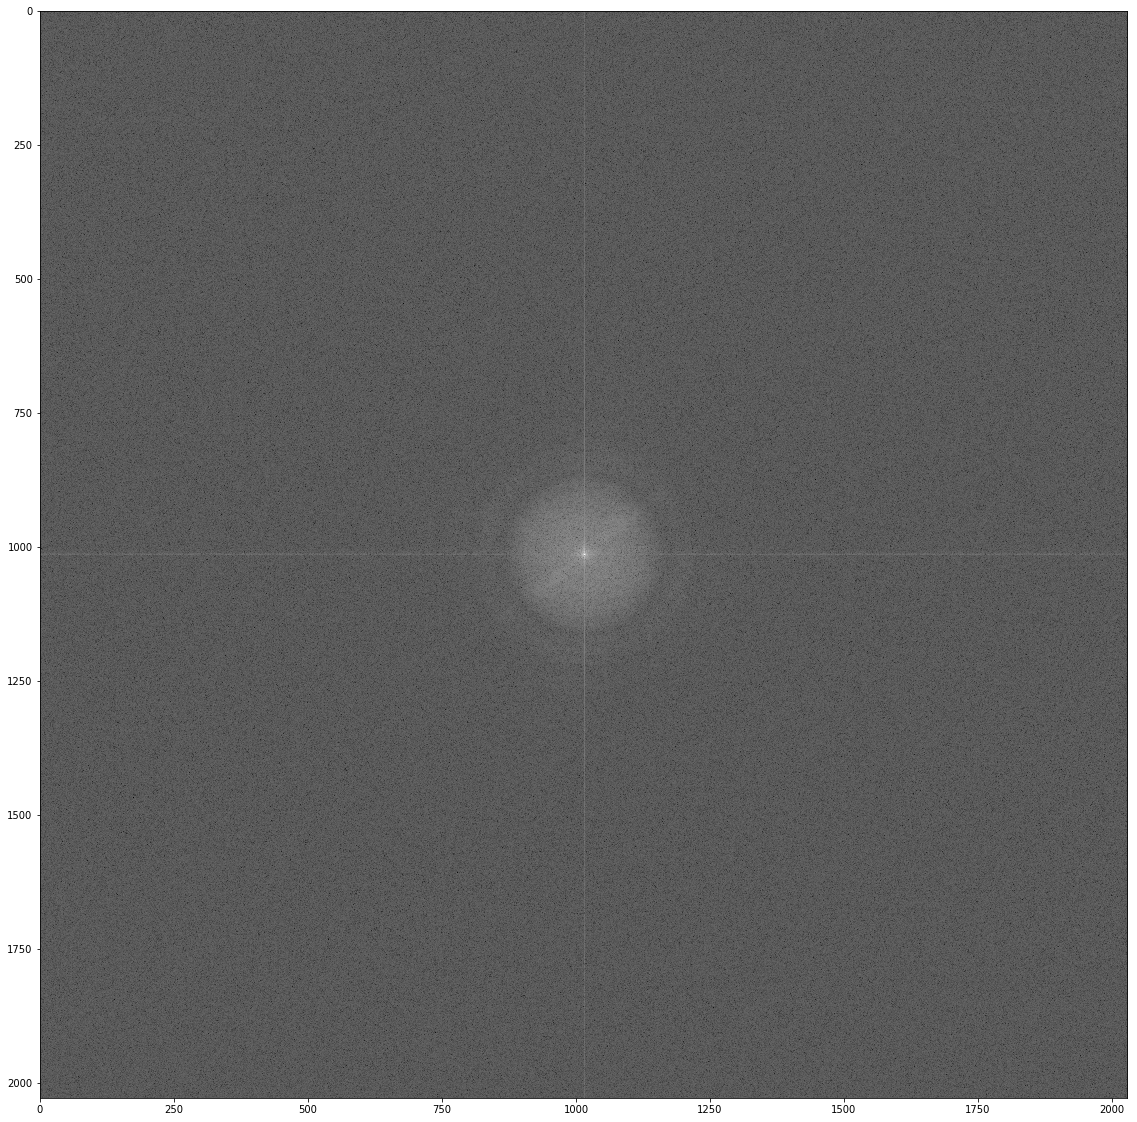

In [24]:
# Fourier transform the image
im = fft2(image)
im = np.log(abs(fftshift(im)))
var.show(im)

Note, Fourier map has some oscillations - this is CTF function. Let's average over all angles and plot the resulting profile.

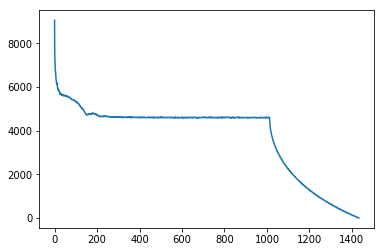

In [25]:
from maximus48 import polar2

im = polar2.reproject_image_into_polar(im)[:,:,0]
im = np.sum(im, axis = 1)
plt.plot(im)

Cut edge regions and substract the baseline

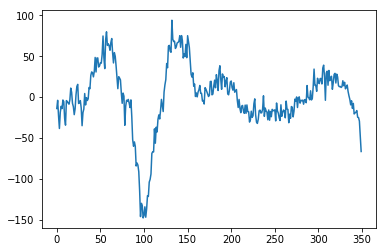

In [26]:
data = im[50:400]
data = polar2.baseline(data)
plt.plot(data)

Fit with polynomial function

/Users/mpolikarpov/anaconda3/envs/tomography/lib/python3.5/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


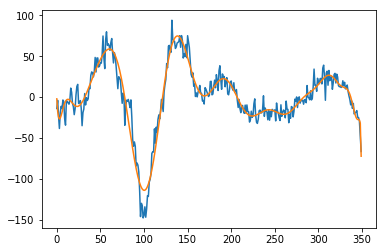

In [27]:
x = np.linspace(0, data.shape[0], len(data), dtype = 'uint16')
y = data
    
pfit = np.polyfit(x, y, 30)                         # returns polynomial coefficients
yp = np.polyval(pfit, x)                            # fits the curve,

plt.plot(data)
plt.plot(yp)
plt.show()

### Calculate theoretical CTF

Text(0.5,1,'Theoretical CTF')

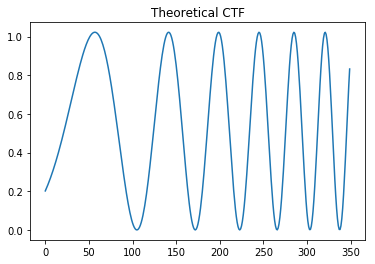

In [28]:
# pixel size of the camera (meters)
pixel = 0.1625* 1e-6  

# photon energy
energy = 18   
wavelength = var.wavelen(energy)

# distance in m
distance = 6.25 * 1e-2              

# beta/delta (see complex refractive index in the publication above)
beta_delta = 0.15 

#fresnel number
fresnelN = pixel**2/(wavelength*distance)
CTF_theory = CTF.CTF_function(image, fresnelN, beta_delta)
plt.plot(CTF_theory[50:400])
plt.title('Theoretical CTF')

### Compare theoretical CTF and CTF from your data

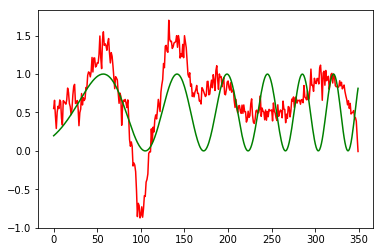

In [31]:
# scale and normalize
scale_a = data
scale_b = CTF_theory[50:400]

scale_a = scale_a/np.max(scale_a) + 0.7#0.6
scale_b = scale_b/np.max(scale_b)

# plot raw data and theoretical CTF
plt.plot(scale_a, 'r')
plt.plot(scale_b, 'g')
plt.show()

Or if you want, you can plot it with a polynomial fit

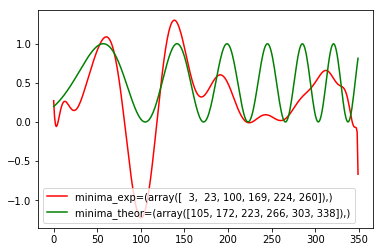

In [33]:
# scale and normalize
scale_a = yp
scale_b = CTF_theory[50:400]

scale_a = scale_a/np.max(scale_a) + 0.3#0.6
scale_b = scale_b/np.max(scale_b)

# calculate extrema if you want 
min_a = argrelextrema(scale_a, np.less)  #np.greater or np.less
min_b = argrelextrema(scale_b, np.less)

# plot raw data and theoretical CTF
plt.plot(scale_a, 'r')
plt.plot(scale_b, 'g')
plt.legend(('minima_exp='+str(min_a),'minima_theor='+str(min_b)))

plt.show()

As you may see, this fit is not bad. Please note, that your goal is to adjust the distance and delta/beta so two curves fit. 
- delta/beta moves the whole curve in parallel (doesn't change period);
- distance changes period of the CTF and moves it                                       

## Multi-distance CTF-reconstruction

In this example we will use four images, acquired at four distances for the CTF reconstruction. Pease note, that more distances don't reduce the number of artifacts in the CTF-reconstruction (see the paper above).

There will be flatfield-correction with SSIM. If you unfamiliar with this, please use the example from the README file.

In [86]:
#set the ROI of image first, the logic corresponds to FIJI (to be read (x,y,x1,y1 at the image - inverse to numpy!)
ROI = (20,20,2048,2048) 

# read data paths 
folder = '/Users/mpolikarpov/data_server/raw_data/tomo/'
data_names = [folder + 'Platy-Platy_9902_1_01800.tiff',
              folder + 'Platy-Platy_9902_2_01800.tiff',
              folder + 'Platy-Platy_9902_3_01800.tiff',
              folder + 'Platy-Platy_9902_4_01800.tiff']

# read flatfield paths 
flatfield_names = np.zeros(4, 'object')
for i in range(flatfield_names.shape[0]):
    flatfield_names[i] = [(folder + im) for im in var.im_folder(folder) if im.startswith('ff_Platy-Platy_9902_'+str(i+1))]

    
# read data
data = tifffile.imread(data_names)[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

#read flatfield
flatfield = np.zeros(4, 'object')
for i in range(flatfield.shape[0]):
    flatfield[i] = tifffile.imread(flatfield_names[i])[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]
    # please transpose the ff-array for the further ff-correction
    flatfield[i] = np.transpose(flatfield[i], (1,2,0))

Now, there are four data files. And 4 sets with 30 flatfield-files for each data file.

In [109]:
# let's do flatfield-correction

result = []
for i in range(data.shape[0]):
    
    # images should be set as special classes:
    image_class = SSIM.SSIM_const(data[i])
    ff_class = SSIM.SSIM_const(flatfield[i])

    # then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
    index = SSIM.SSIM(image_class, ff_class).ssim()

    # now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
    result.append(data[i]/flatfield[i][:,:,np.argmax(index)])

Text(0.5,1,'Distance 4')

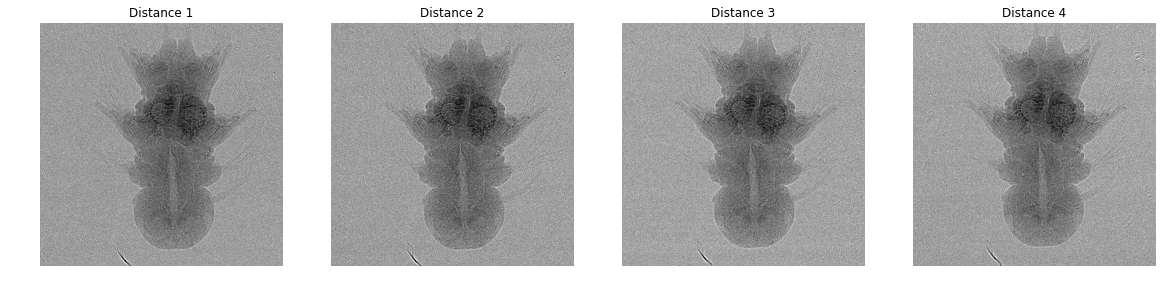

In [95]:
# let's see the result for all 4 images

# show results 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,18),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(result[0])
ax[0].axis('off')
ax[0].set_title('Distance 1')

ax[1].imshow(result[1])
ax[1].axis('off')
ax[1].set_title('Distance 2')

ax[2].imshow(result[2])
ax[2].axis('off')
ax[2].set_title('Distance 3')

ax[3].imshow(result[3])
ax[3].axis('off')
ax[3].set_title('Distance 4')

Images are almost identical, but not really. 
- First, phase contrast is slightly different due to different distances. 
- Plus, they are a bit shifted relative to each other. So, you will have to compensate for shifts when making CTF-reconstruction.
- You should also pad images at their edges to avoid reconstruction artifacts.
- Only after you can retrieve the phase.

Let's make all this.

In [110]:
# calculate shift of the image between the i-th and the 1-st distance
from maximus48 import multiCTF2 as multiCTF

shift = []

for i in np.arange(len(result)):
    shift.append(multiCTF.shift_distance(result[0], result[i], 100))

print(shift)

[array([0., 0.]), array([0.75, 6.94]), array([14.15, 14.58]), array([24.65, 29.9 ])]


As you see, the shift is not negligible.

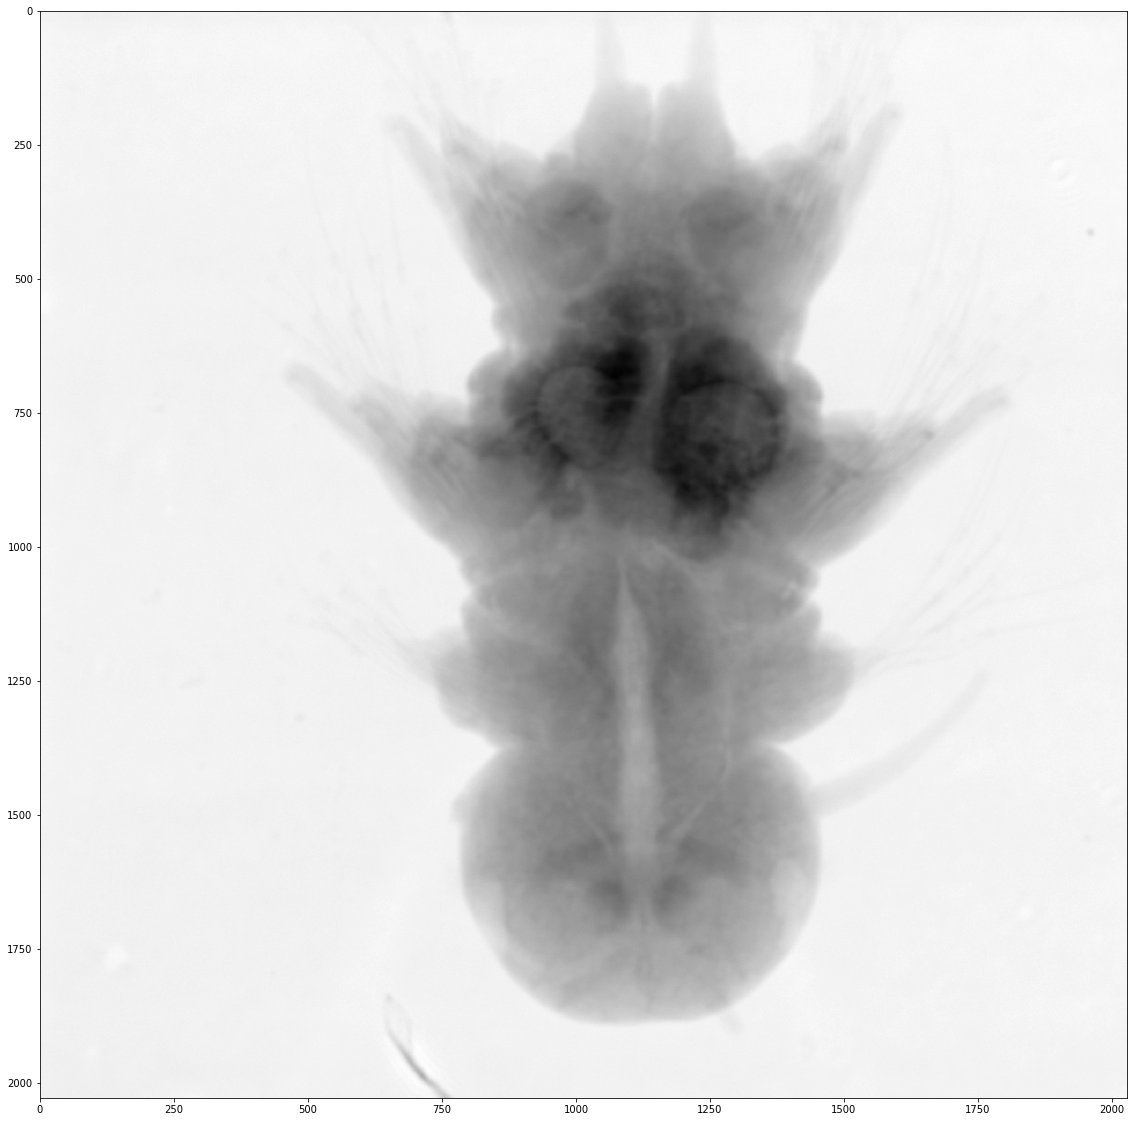

In [116]:
# Now, let's shift images 
out = multiCTF.shift_imageset(np.asarray(result), np.asarray(shift))
out = np.asarray(out)


# pixel size
pixel = 0.1625 * 1e-6                                                           

# distances 
distance = np.array((6.25, 6.75, 7.35, 8.25), dtype = 'float32') * 1e-2                # distances of your measurements 

# photon energy
energy = 18   
wavelength = var.wavelen(energy)

# CTF parameters
beta_delta = 0.1
zero_compensation = 0.1


# Padding - in pixels for each side
Npad = 200
out = np.pad(out, ((0,0),(Npad, Npad),(Npad, Npad)), 'edge')  

# CTF-retrieval
fresnelN = pixel**2/(wavelength*distance)
final = multiCTF.multi_distance_CTF(out, beta_delta, fresnelN, zero_compensation)

# unpad images and show the result
final = final[Npad:(final.shape[0]-Npad),Npad:(final.shape[1]-Npad)]                           
var.show(final)

Compare with a single-distance CTF phase-retrieval


In [119]:
from maximus48 import monochromaticCTF as CTF

oneD = CTF.single_distance_CTF(out[0], beta_delta, fresnelN[0], zero_compensation)
oneD = oneD[Npad:(oneD.shape[0]-Npad),Npad:(oneD.shape[1]-Npad)]   

Text(0.5,1,'1-distance CTF reconstruction')

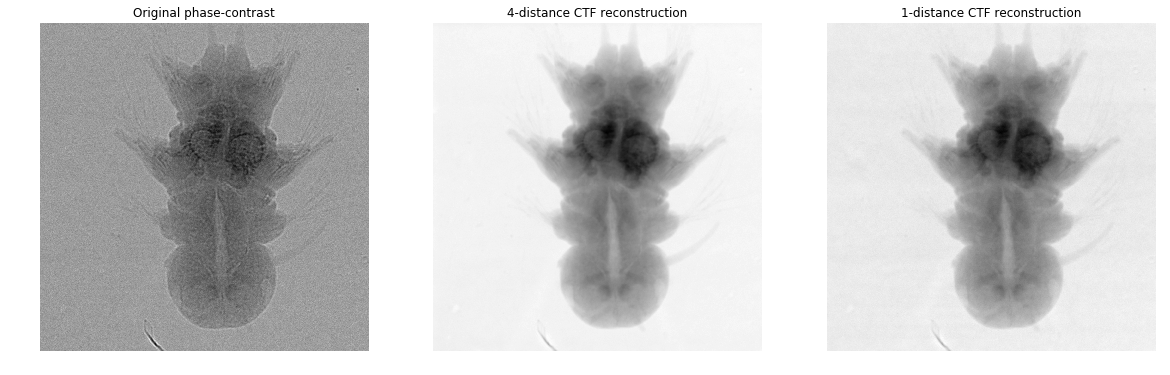

In [124]:
# show results 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(result[0])
ax[0].axis('off')
ax[0].set_title('Original phase-contrast')

ax[1].imshow(final)
ax[1].axis('off')
ax[1].set_title('4-distance CTF reconstruction')

ax[2].imshow(oneD)
ax[2].axis('off')
ax[2].set_title('1-distance CTF reconstruction')

Text(0.5,1,'1-distance CTF reconstruction')

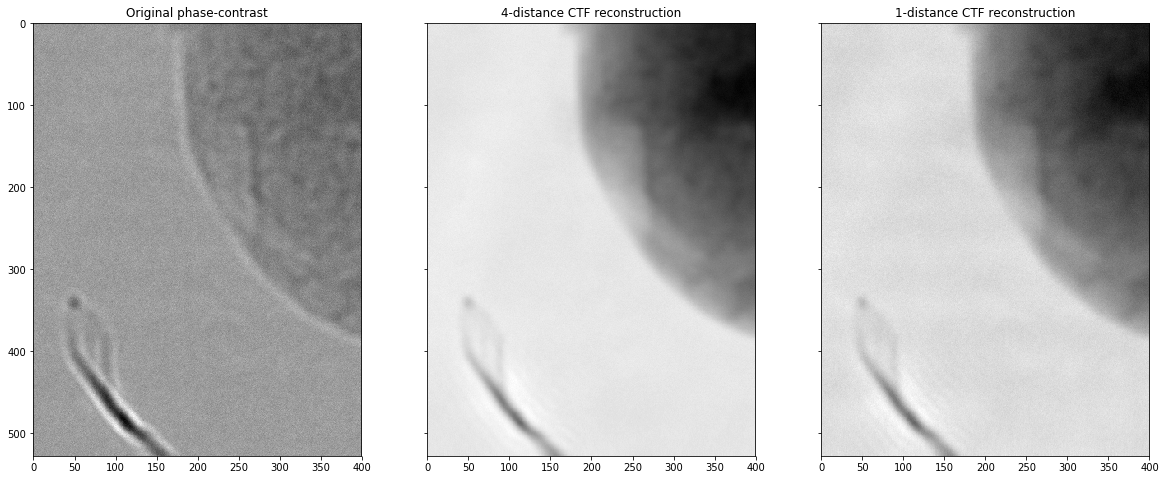

In [127]:
# or with better imagnification

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,18),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(result[0][1500:, 600:1000])
#ax[0].axis('off')
ax[0].set_title('Original phase-contrast')

ax[1].imshow(final[1500:, 600:1000])
#ax[1].axis('off')
ax[1].set_title('4-distance CTF reconstruction')

ax[2].imshow(oneD[1500:, 600:1000])
#ax[2].axis('off')
ax[2].set_title('1-distance CTF reconstruction')

As you may see, 4-distance reconstruction has less stripy artifacts.
Please note, that multiCTF.multi_distance_CTF() function will also work with any number of images/distances.